# Imports

In [1]:
import re
import random
import os, subprocess
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchvision.datasets.mnist import MNIST

from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

from diffusion import DDPM, ForwardDiffusion, ReverseDiffusion, get_beta_schedule
from unet import LabeledDataset, get_labeled_data_loader, MyUNet
from smallnet import LinearNet, Net, split_dataset


MODELS_DIR = "models"
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
SAVE_DPPM_MNIST_PATH = f"{MODELS_DIR}/ddpm_mnist.pt"

# Downloads

In [2]:
!pip install -U gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [3]:
# Downloading pretrained model
!gdown -O "models/ddpm_mnist.pt" "https://drive.google.com/uc?id=1fSPB08M6aBNmhjRgSn3qpdq5hXl1Xhao"

Downloading...
From: https://drive.google.com/uc?id=1fSPB08M6aBNmhjRgSn3qpdq5hXl1Xhao
To: /content/models/ddpm_mnist.pt
100% 5.26M/5.26M [00:00<00:00, 120MB/s]


## MNIST Dataset

In [ ]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*x - 1)  # Normalize MNIST data
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, test_indices = split_dataset(train_dataset, num_train_per_class=32, num_test_per_class=64)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 409669424.79it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 16696856.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 184734123.90it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19204162.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Denoising Diffusion Probabilistic Model (DDPM)

In [7]:
def train_DDPM(ddpm: DDPM, dataloader: DataLoader, lr: float, weight_decay: float, n_iters: int, device: str = "cpu", log_every: int = 500):
    ddpm = ddpm.to(device)
    optimizer = th.optim.AdamW(ddpm.model.parameters(), lr=lr, weight_decay=weight_decay)
    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < n_iters:
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)
        x, y = batch["x"].to(device), batch["y"].to(device)

        loss = ddpm.train_loss(x, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{n_iters} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0
        step += 1

In [9]:
T = 1000
BATCH_SIZE = 1024
LR = 0.01
WEIGHT_DECAY = 0.0
N_ITERS = 5000

device = th.device("cuda" if th.cuda.is_available() else "cpu")

model_dif = MyUNet()

if not os.path.exists(SAVE_DPPM_MNIST_PATH):
    print("Pretrained model does not exist, start training")
    th.manual_seed(0)
    random.seed(0)
    ddpm = DDPM(betas=get_beta_schedule(T), model=model_dif, clip_x0=True)
    dataloader = get_labeled_data_loader(train_dataset, test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_DDPM(ddpm=ddpm, dataloader=dataloader, lr=LR, weight_decay=WEIGHT_DECAY, n_iters=N_ITERS, device=device)
    th.save(ddpm.to("cpu").state_dict(), SAVE_DPPM_MNIST_PATH)
else:
    print("Loaded a pretrained model")
    ddpm = DDPM.from_pretrained(model_dif, SAVE_DPPM_MNIST_PATH)

_ = ddpm.to(device)

Loaded a pretrained model


/content/diffusion.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("clip_x0", th.tensor(clip_x0, dtype=bool))


# Training Simple Neural Net

In [ ]:
def train_model(train_loader, t_up, batch_size, model, criterion, optimizer, model_dif, forward_diffusion, epochs=90, loss_list=[]):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
            outputs = model(features)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    th.save({'model_state_dict': model.state_dict()}, f'/content/{folder}/{t_up}-Lin.pth')
    return loss_list


def extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion):
    """
    Extracts features, namely concatenates averaged arrays from different layers of the diffusion model with the UNet architecture.
    :t_up: from which step of the forward diffusion process image is needed.
    :model_dif: a diffusion model.
    :forward_diffusion: forward diffusion process.
    :return: a tensor of shape [batch_size, 80].
    """
    with torch.no_grad():
        Xs = forward_diffusion.q_sample(x0=images, t=(th.ones(images.shape[0], device=images.device) * (t_up)).long()).to(device)
        t = th.tensor([t_up] * batch_size).to(device)
        features = model_dif.get_features(x=Xs, t=t, y=labels)
    return features


def test_model(model, test_loader, t_up, batch_size, forward_diffusion, model_dif=model_dif):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = extract_features(images, labels, t_up, batch_size, model_dif, forward_diffusion)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

In [ ]:
input_size = 80
num_classes = 10
epochs = 90
T = 1000
forward_diffusion = ForwardDiffusion(betas=get_beta_schedule(T))
t_up = 50

folder = 'smallclassifier'
#os.mkdir(folder)
PATH = f"/content/{folder}/{t_up}-NonLin.pth"
loss_list = []

model = Net(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_list = train_model(train_loader, t_up, batch_size, model, criterion, optimizer, model_dif, forward_diffusion, epochs=epochs)
accuracy = test_model(model, test_loader, t_up, batch_size, forward_diffusion, model_dif=model_dif)
accuracy

Epoch 1, Loss: 2.249542498588562
Epoch 2, Loss: 2.1148723363876343
Epoch 3, Loss: 1.9777890205383302
Epoch 4, Loss: 1.831527316570282
Epoch 5, Loss: 1.6819044470787048
Epoch 6, Loss: 1.5393608808517456
Epoch 7, Loss: 1.4059710264205934
Epoch 8, Loss: 1.2852443337440491
Epoch 9, Loss: 1.1802040815353394
Epoch 10, Loss: 1.0755838096141814
Epoch 11, Loss: 0.9870641529560089
Epoch 12, Loss: 0.9126536250114441
Epoch 13, Loss: 0.8323376417160034
Epoch 14, Loss: 0.7699703693389892
Epoch 15, Loss: 0.7148393630981446
Epoch 16, Loss: 0.661682802438736
Epoch 17, Loss: 0.6183143705129623
Epoch 18, Loss: 0.5696436047554017
Epoch 19, Loss: 0.5368057578802109
Epoch 20, Loss: 0.5045085579156876
Epoch 21, Loss: 0.4748412311077118
Epoch 22, Loss: 0.4412767618894577
Epoch 23, Loss: 0.4247994363307953
Epoch 24, Loss: 0.4006680607795715
Epoch 25, Loss: 0.38086671233177183
Epoch 26, Loss: 0.36081101149320605
Epoch 27, Loss: 0.35200500637292864
Epoch 28, Loss: 0.33463225662708285
Epoch 29, Loss: 0.3168968752

94.84375

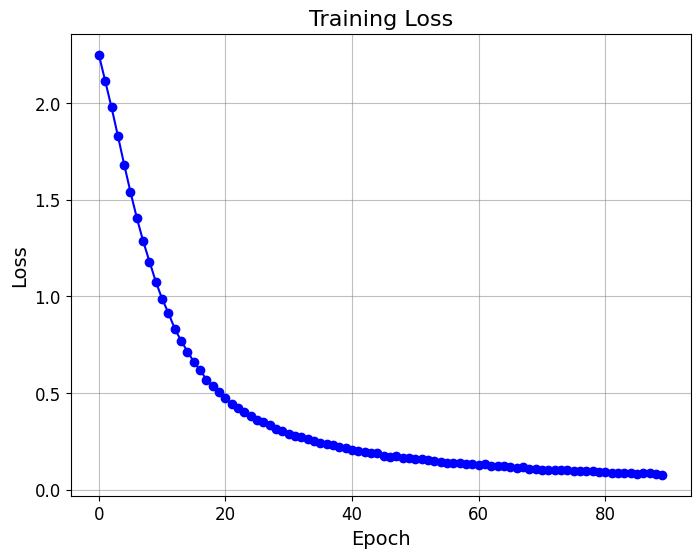

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(loss_list, marker='o', color='blue', linestyle='-')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss', fontsize=16)
plt.grid(True, color='gray', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Optimal timestep selection

### Linear Model

In [ ]:
random.seed(42)

folder = 'linearnet'
PATH = f"/content/{folder}/ML/50-Lin.pth"

input_size = 80
num_classes = 10  # Number of classes in MNIST
epochs = 90
batch_size = 32
T = 1000
forward_diffusion = ForwardDiffusion(betas=get_beta_schedule(T))

t_ups = [3, 5, 10, 15, 20, 25, 30, 50, 100, 250, 500, 600, 700, 800, 900, 950, 990, 999]
scores = []


for t_up in t_ups:
    print(f'\nStep: {t_up}')

    model = LinearNet(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(train_loader, t_up, batch_size, model, criterion, optimizer, model_dif, forward_diffusion, epochs=epochs)
    accuracy = test_model(model, test_loader, t_up, batch_size, forward_diffusion, model_dif=model_dif)
    scores.append(accuracy)

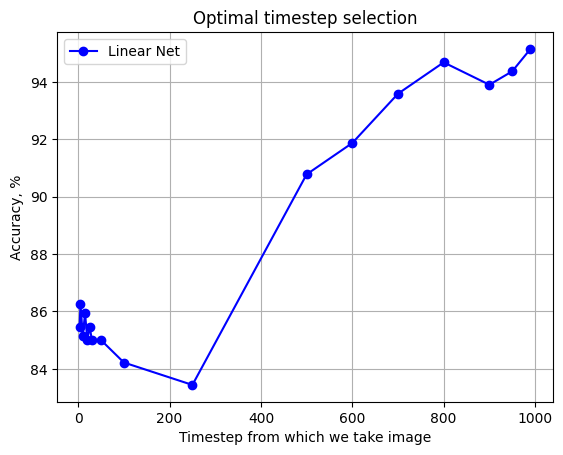

In [ ]:
plt.plot(t_ups[:-3], scores, marker='o', color='blue', label='Linear Net')
plt.xlabel('Timestep from which we take image')
plt.ylabel('Accuracy, %')
plt.title('Optimal timestep selection')
plt.grid(True)
plt.legend()
plt.show()